# AdaBoost

A quick reminder on how AdaBoost works: https://youtu.be/LsK-xG1cLYA BAM! Note that this video uses Gini index instead of Entropy and resamples the dataset instead of summing the error weights, but the general approach is the same as the one presented in the lecture.

Key ideas:
* training: train multiple weak learners and assign them a weighted vote
* classification: predict the class that gets the most weighted votes

Advantages:
* simple (few parameters)
* robust to noisy training
* performs well in practice

Disadvantages:
* needs a termination condition (requires meta-optimisation)
* sensitive to outliers

## Algorithm
Given a set of $m$ training instances, $S=\{(x_1, y_1),... ,(x_m, y_m)\}$, with $x_i \in X$ (where $X$ is a typical dataset, for example $\mathbb{R}^d$) and $y_i \in \{-1, +1\}$ for $i=1,...,m$.

Training:

1. Initiate the observation weights using the uniform distribution $D_1(i) = {1 \over m}$, where $i=1,...,m$ represents an instance.
1. For each iteration $t=1,...,T$:
  1. Fit a weak classifier $h_t$ on the training data, using weights from $D_t$.
  1. Compute weighted training error of classifier $h_t$:
  $$
  \epsilon_t = err_{D_t}(h_t) = Pr_{D_t}(\{x|y \neq h_t(x)\})
  $$
  1. Compute the weight of the "vote" of classifier $h_t$:
  $$
  \alpha_t = {1 \over 2}ln{1-\epsilon_t \over \epsilon_t}
  $$
  1. Update the observation weights using the update rule:
  $$
  D_{t+1}(i)={1 \over Z_t} D_t(i)e^{-\alpha_t y_i h_t(x_i)}, 
  $$
  for $i=1,...,m$ and $ \forall t \geq 1$, where $Z_t$ is the normalisation factor (such that the sum of all values in $D_{t+1}$ remains 1).
  
Classification:

1. Output the weighted majority vote:
$$
H_T(x) = sign(\sum_{t=1}^T \alpha_t h_t(x))
$$

Note that the algorithm doesn't specify how the weak classifier $h_t$ should look like. In practice (and in the examples below) we will typically use a decision tree classifier with a single decision node.

## Classification

Given a dataset like the following:

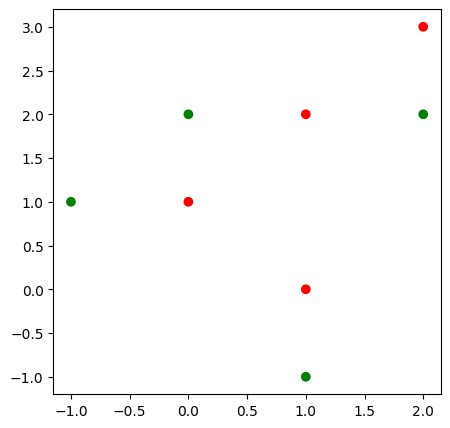

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
d = pd.DataFrame({
    'X1': [-1, 0, 0, 1, 1, 1, 2, 2],
    'X2': [1, 1, 2, -1, 0, 2, 2, 3],
    'Y': [0, 1, 0, 0, 1, 1, 0, 1]
})
X, Y = d[['X1', 'X2']], d['Y']

c= ['green' if l == 0 else 'red' for l in Y]
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(X['X1'], X['X2'], color=c)
plt.show()

we can use [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) from [`sklearn.ensemble`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble) to classify the point at (0, 0) using 5 weak learners with:

In [2]:
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier(algorithm="SAMME", n_estimators=5).fit(X, Y)
ab.predict(pd.DataFrame([[0, 0]], columns=['X1', 'X2']))

array([1])

We can visualise the decision surface using `matplotlib`:

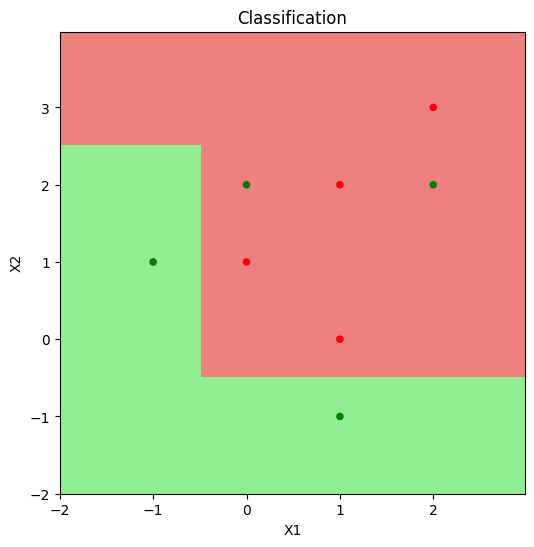

In [3]:
from tools.plots import plot_decision_surface
ab = AdaBoostClassifier(algorithm="SAMME", n_estimators=5).fit(X, Y)
plot_decision_surface(ab, X, Y)

In the particular case where the number of estimators is 1, the decision surface corresponds of a simple decision tree with a single split (usually called "decision stump"):

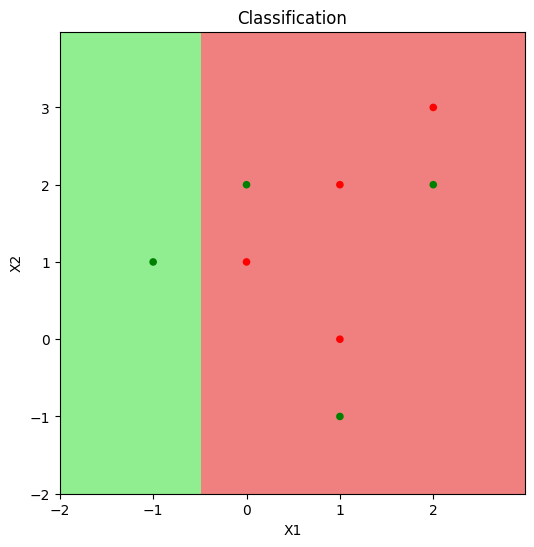

In [4]:
ab = AdaBoostClassifier(algorithm="SAMME", n_estimators=1).fit(X, Y)
plot_decision_surface(ab, X, Y)

Some of the most useful attributes provided by this learner are:

* `classes_` Class labels known to the classifier.
* `estimators_` The collection of fitted sub-estimators (each $h_t$ in from the algorithm).
* `estimator_weights_` Weights for each estimator in the boosted ensemble. Note that `sklearn` uses a version of the algorithm where the weight are not multiplied by $1/2$, so these values are actually equal to $2 \alpha_t$ from the algorithm.
* `estimator_errors_` Classification error for each estimator in the boosted ensemble (each $\epsilon_t$ from the algorithm).

---
**Give it a try!**

For the dataset below, find the weak learner and calculate $\epsilon_1$ and $\alpha_1$, then compare your results with `estimator_errors_` and `estimator_weights_` for `AdaBoostClassifier(algorithm="SAMME", n_estimators=1)`.

In [5]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
d1 = pd.DataFrame({
    'Chest Pain': [1, 0, 1, 1, 0, 0, 1, 1],
    'Blocked Arteries': [1, 1, 0, 1, 1, 1, 0, 1],
    'Patient Weight': [205, 180, 210, 167, 156, 125, 168, 172],
    'Heart Disease': [1, 1, 1, 1, 0, 0, 0, 0]
})
X1, y1 = d1[['Chest Pain', 'Blocked Arteries', 'Patient Weight']], d1['Heart Disease']
# Your code here

Expected results:

* $\epsilon_1$:  1/8 = 0.126
* $\alpha_1$: 1.9459101490553132

---

## Specifying the weak learner

By default, this will use a `DecisionTreeClassifier` with `criterion='gini'` and `max_depth=1`. This can be configured through the `base_estimator` parameter. For example, if we want to use the entropy as a selection criterion for the underlying weak learner and to change `max_depth` to 2, we can specify it like this:

In [6]:
from sklearn.tree import DecisionTreeClassifier
be = DecisionTreeClassifier(criterion='entropy', max_depth=2)
ab = AdaBoostClassifier(estimator=be, algorithm="SAMME", n_estimators=1).fit(X, Y)

Plotting the decision surface of the AdaBoost classifier now shows a more complex decision surface even if `n_estimators` is still 1, which confirms that `max_depth` has been changed:

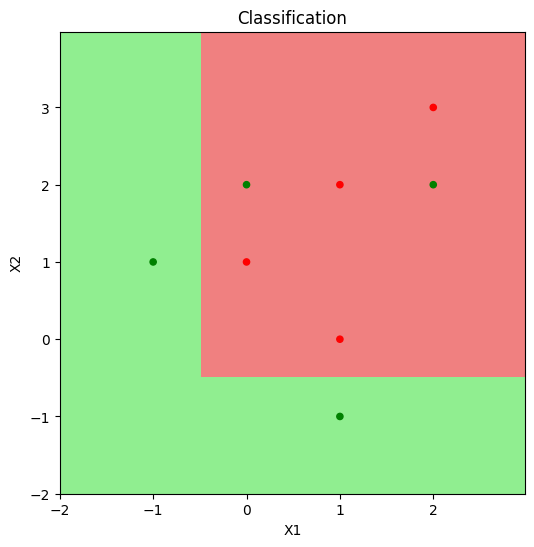

In [7]:
plot_decision_surface(ab, X, Y)

## Accuracy

Training and cross-validation can be performed just like for any algorithm, using `AdaBoostClassifier.score()` and `sklearn.model_selection.cross_val_score`.

---
**Give it a try!**

For the `breast_cancer` dataset, compare the accuracy of `AdaBoostClassifier(algorithm="SAMME")` with that of a `DecisionTreeClassifier(criterion='entropy')` using 5-fold cross-validation.

In [8]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
# Your code here

Expected result:

```
AdaBoost:  0.9666200900481291
ID3: 0.9367489520260829
```
---